<a href="https://colab.research.google.com/github/crystalleat/Rule606_Broker_Routing_Risk/blob/main/BrokerDealer_Routing_Behavior_%26_Incentives_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0.0 Overview**

 This notebook analyzes broker order routing practices using SEC Rule 606 quarterly disclosures to identify potential risks related to market concentration, routing consistency, and payment-for-order-flow incentives. The dataset spans multiple brokers, three security types (Options, Other Stocks, SP500), and covers a multi-year period at monthly and quarterly levels.

**The workflow includes:**

**Data Preparation:** Parsing and cleaning broker disclosures, aligning firm, venue, and order-type metrics.

**Market Concentration Analysis:** Calculating Herfindahl-Hirschman Index (HHI) by firm and security type.

**Routing Consistency:** Measuring volatility in venue usage over time.

**Incentive Analysis:** Deriving Cents-per-Hundred-shares (CPH) metrics for market, marketable limit, and non-marketable limit orders.

**Composite Routing Risk Scoring:** Combining normalized HHI, CPH, and consistency metrics for an overall routing risk indicator.

Final Outputs are exported as structured CSVs for Tableau dashboards, enabling interactive trend analysis and cross-broker comparisons to support compliance, risk management, and market structure research.



#**1.0 Data Ingestion**

##**1.1 Reporting Period Selection**

**Reporting Period Selection:** This block defines the time range parameters (years and quarters) that control which Rule 606 broker disclosure files are retrieved and processed. By explicitly listing years and quarters, the analysis remains reproducible and easy to adjust without changing the core processing logic.

In [1]:
# Adjustable settings: choose the years and quarters to include in the analysis
# Used to build URLs and control which Rule 606 files are processed

years = ["2022", "2023", "2024","2025"]
quarters = ["Q1", "Q2", "Q3", "Q4"]

#**2.0 Data Acquisition - Functions (definitions only)**

##**2.1 Fidelity Rule 606 Link Builder**

**Fidelity Rule 606 Link Builder:** This function dynamically constructs a list of Fidelity Rule 606 XML file URLs for the specified years, quarters, and broker prefixes (default: FBS and NFS). Each URL is packaged with metadata (firm name, quarter, year) to support both downloading and later filtering/analysis.



In [2]:
# Given a Fidelity link, pull the Rule 606 XML data. This code is specifically for FBS and NFS.
# Link Sample: https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/nfs-q4-2024.xml

from typing import List, Dict

# Constructs URLs for Rule 606 XML files from Fidelity’s site (FBS/NFS), based on their filename structure.
# Generates a list of dictionaries, each containing an XML URL and related metadata.

def build_fidelity_links(
    years: List[str],
    quarters: List[str],
    prefixes: List[str] = ["fbs", "nfs"]
) -> List[Dict[str, str]]:

    # Base URL with a placeholder for filename
    base_url = "https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/{filename}.xml"
    links = []

    # Loop through each combination of broker prefix, year, and quarter
    for prefix in prefixes:
        for year in years:
            for quarter in quarters:
                # Construct the filename in Fidelity’s format: nfs-q4-2024
                filename = f"{prefix}-{quarter.lower()}-{year}"
                url = base_url.format(filename=filename)
                # Map prefix to full broker name
                firm_name = "Fidelity Brokerage Services LLC" if prefix == "fbs" else "National Financial Services LLC"

                # Add structured dictionary with metadata and URL
                links.append({
                    "url": url,
                    "firm": firm_name,
                    "quarter": quarter,
                    "year": year
                })

    return links



##**2.2 Schwab Rule 606 Link Builder**

**Schwab Rule 606 Link Builder:** This function builds a complete list of Charles Schwab Rule 606 XML URLs across selected years and quarters, handling both Schwab’s legacy (pre‑2024) and modern (2024+) file‑naming/hosting patterns. Each URL is returned with firm and period metadata for downstream download and filtering.



In [3]:
## Given a Schwab Link, pull the Rule 606 XML data. This code is specifically for Schwab
# Link Sample (pre-2024): https://public.s3.com/rule606/chas/606-CHAS-2020Q2.xml
# Link Sample (2024+): https://content.schwab.com/drupal_dependencies/psr/606/2025-Q1-Schwab-Quarterly-Report.xml

# Constructs URLs for Rule 606 XML files from Schwab's site (CHAS), based on their filename conventions.
# Generates a list of dictionaries, each containing an XML URL and related metadata.

def build_schwab_links_combined(
    years: List[str],
    quarters: List[str]
) -> List[Dict[str, str]]:

    links = []

    # Iterate through all combinations of years and quarters
    for year in years:
        for quarter in quarters:
            # Handle legacy Schwab link structure (pre-2024)
            if int(year) < 2024:
                filename = f"606-CHAS-{year}{quarter}"
                url = f"https://public.s3.com/rule606/chas/{filename}.xml"

            # Handle modern Schwab link structure (2024+)
            else:
                filename = f"{year}-{quarter}-Schwab-Quarterly-Report"
                url = f"https://content.schwab.com/drupal_dependencies/psr/606/{filename}.xml"

            # Add structured metadata and URL to the list
            links.append({
                "url": url,
                "firm": "Charles Schwab",
                "quarter": quarter,
                "year": year
            })

    return links


##**2.3 XML Parsing - Common Extractor**

**XML Parsing - Common Extractor:** Parses a single Rule 606 XML file (Fidelity or Schwab) and returns one flat record per venue × month × category. It guards against broken links, non‑XML responses, and malformed XML, and it uses a browser‑style User-Agent header to avoid Schwab’s 2024+ 403 blocks.



In [4]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from typing import List, Dict, Any

# Extracts Rule 606 venue-level data from a single broker XML file
# Returns a list of flat dictionaries (one per venue per month per category)

def extract_data_from_xml(
    url: str,
    firm: str,
    quarter: str,
    year: str,
    check_status: bool = True,
    verbose: bool = False
) -> List[Dict[str, Any]]:

    # Helper function to flatten each Venue element into a dictionary
    def parse_venue_data(rvenue, category, month):
        return {
            "firm": firm,
            "quarter": quarter,
            "year": year,
            "month": month,
            "security_type": category,
            "venue_name": rvenue.findtext("name"),
            "mpid": rvenue.findtext("mic"),
            "order_pct": rvenue.findtext("orderPct"),
            "market_pct": rvenue.findtext("marketPct"),
            "marketable_limit_pct": rvenue.findtext("marketableLimitPct"),
            "non_marketable_limit_pct": rvenue.findtext("nonMarketableLimitPct"),
            "other_pct": rvenue.findtext("otherPct"),
            "net_pmt_paid_recv_market_orders_usd": rvenue.findtext("netPmtPaidRecvMarketOrdersUsd"),
            "net_pmt_paid_recv_market_orders_cph": rvenue.findtext("netPmtPaidRecvMarketOrdersCph"),
            "net_pmt_paid_recv_marketable_limit_orders_usd": rvenue.findtext("netPmtPaidRecvMarketableLimitOrdersUsd"),
            "net_pmt_paid_recv_marketable_limit_orders_cph": rvenue.findtext("netPmtPaidRecvMarketableLimitOrdersCph"),
            "net_pmt_paid_recv_non_marketable_limit_orders_usd": rvenue.findtext("netPmtPaidRecvNonMarketableLimitOrdersUsd"),
            "net_pmt_paid_recv_non_marketable_limit_orders_cph": rvenue.findtext("netPmtPaidRecvNonMarketableLimitOrdersCph"),
            "net_pmt_paid_recv_other_orders_usd": rvenue.findtext("netPmtPaidRecvOtherOrdersUsd"),
            "net_pmt_paid_recv_other_orders_cph": rvenue.findtext("netPmtPaidRecvOtherOrdersCph"),
            "material_aspects": rvenue.findtext("materialAspects"),
        }

    try:
        # Add browser-style headers to bypass Schwab's 403 Forbidden error on newer files
        # This issue came up when Schwab switched hosting in 2024+—their server blocks requests without a User-Agent header. Adding this header mimics a browser to allow access.
        headers = { "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(url, headers=headers, timeout=10)

        # Skip broken links or HTML error pages
        # This check prevents the pipeline from crashing if a file doesn't exist or isn't public
        if response.status_code != 200:
            if verbose:
                print(f"[WARNING] {url} returned status {response.status_code}")
            return []

        # Skip responses that are not actual XML (e.g., HTML error pages returned by Schwab)
        content_type = response.headers.get("Content-Type", "")
        if "xml" not in content_type.lower():
            if verbose:
                print(f"[WARNING] {url} returned non-XML content: {content_type}")
            return []

        # Parse the valid XML response
        root = ET.fromstring(response.content)
        data = []

        # Loop over each reporting month block in the XML
        for rmonthly in root.findall(".//rMonthly"):
            month = rmonthly.findtext("mon")

            # Loop over each product category
            for category_tag, category_name in [
                ("rSP500", "SP500"),
                ("rOtherStocks", "OtherStocks"),
                ("rOptions", "Options"),
            ]:
                #Extracts data from each venue in each category and builds up the full data list, one record per venue per month per category
                section = rmonthly.find(category_tag)
                if section is not None:
                    # Loop over each execution venue inside the category
                    for rvenue in section.findall(".//rVenue"):
                        venue_data = parse_venue_data(rvenue, category_name, month)
                        data.append(venue_data)

        # Log number of records extracted (for debugging or tracking progress)
        if verbose:
            print(f"[INFO] Extracted {len(data)} records from {url}")

        return data

    # Handle corrupted or poorly formatted XML files without crashing the pipeline
    except ET.ParseError as e:
        if verbose:
            print(f"[ERROR] XML parsing error for {url}: {e}")
        return []

    # Handle other unexpected errors (connection issues, missing fields, etc.)
    except Exception as e:
        if verbose:
            print(f"[ERROR] Failed to process {url}: {e}")
        return []


##**2.4 Batch Download & Parse**

**Process Links to DataFrame:** Iterates over a list of broker‑quarter XML links, calls extract_data_from_xml() for each, and aggregates all venue×month×category records into a single DataFrame.



In [5]:
# Processes a list of Rule 606 XML file links and returns a combined DataFrame
# Calls extract_data_from_xml() for each broker-quarter combination
def process_links_to_dataframe(
    links: List[Dict[str, Any]],
    check_status: bool = True,
    verbose: bool = False
) -> pd.DataFrame:

    all_data = []

    # Loop through each document link and extracts data tagging each with the firm quarter and year as it goes through
    for link in links:
        url = link["url"]
        firm = link["firm"]
        quarter = link["quarter"]
        year = link["year"]

        # Extract venue-level records from the XML
        data = extract_data_from_xml(url, firm, quarter, year, check_status, verbose)

        #Add to the master list
        all_data.extend(data)

    # Convert the combined list of dictionaries to a DataFrame
    df = pd.DataFrame(all_data)

    # # Drop 'month' column if exists
    # if 'month' in df.columns:
    #     df = df.drop(columns=['month'])

    #Logs the number of rows and volumns to confirm that data was successfully pulled
    if verbose:
        print(f"[INFO] Final DataFrame shape: {df.shape}")

    return df



#**3.0 Data Cleaning & Typing - Functions (definitions only)**

**Data Cleaning & Typing - Functions (definitions only):** Casts identifier fields (firm, venue, year/quarter, etc.) to categorical to cut memory and speed up groupbys/joins, and converts all percentage and payment fields to numeric using pd.to_numeric(..., errors='coerce'). This standardizes types coming from XML (strings) so later aggregation and scoring work reliably.

In [6]:
# Converts selected columns to categorical or numeric types
# Optimizes memory usage and ensures proper data types for analysis
def convert_column_types(
    df: pd.DataFrame,
    categorical_columns: List[str] = None,
    numeric_columns: List[str] = None,
    verbose: bool = False
) -> pd.DataFrame:

    if categorical_columns is None:
        categorical_columns = ['firm', 'quarter', 'security_type', 'year', 'venue_name', 'mpid']

    if numeric_columns is None:
        numeric_columns = [
            'order_pct', 'market_pct', 'marketable_limit_pct',
            'non_marketable_limit_pct', 'other_pct',
            'net_pmt_paid_recv_market_orders_usd', 'net_pmt_paid_recv_market_orders_cph',
            'net_pmt_paid_recv_marketable_limit_orders_usd', 'net_pmt_paid_recv_marketable_limit_orders_cph',
            'net_pmt_paid_recv_non_marketable_limit_orders_usd', 'net_pmt_paid_recv_non_marketable_limit_orders_cph',
            'net_pmt_paid_recv_other_orders_usd', 'net_pmt_paid_recv_other_orders_cph'
        ]

    # Convert categorical columns
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
            if verbose:
                print(f"[INFO] Converted '{col}' to categorical.")

    # Convert numeric columns
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if verbose:
                print(f"[INFO] Converted '{col}' to numeric.")
        else:
            if verbose:
                print(f"[WARNING] Column '{col}' not found in DataFrame.")

    return df


# **4.0 Data Acquisition - Execution**

**Table 1. Monthly Venue-Level Metrics from Rule 606**

Column Name | Description  
--|--  
firm | Broker-dealer name (e.g., “Fidelity Brokerage Services LLC”, “Charles Schwab”).  
date | Month reference date (month start set during processing).  
yr_qtr_mo | Year–Quarter–Month label `YYYY–QX–MM` (e.g., `2024–Q3–07`).  
security_type | Product bucket (e.g., SP500, OtherStocks, Options).  
hhi_monthly | Monthly HHI concentration across venues for the broker/security type.  
yr_qtr | Year–Quarter label `YYYY–QX` (e.g., `2024–Q3`).  
venue_name | Execution venue receiving routed orders.  
order_pct | Share of total orders routed to this venue (% of broker’s flow for the month/security type).  
market_pct | Market orders share routed to this venue (percent of broker’s monthly flow).  
marketable_limit_pct | Marketable limit orders share routed to this venue (percent).  
non_marketable_limit_pct | Non-marketable limit orders share routed to this venue (percent).  
other_pct | “Other” orders share routed to this venue (percent).  
net_pmt_paid_recv_market_orders_usd | Net payment/fee for market orders at this venue (USD total in month).  
net_pmt_paid_recv_market_orders_cph | Net payment/fee for market orders (cents per 100 shares) at this venue/month.  
net_pmt_paid_recv_marketable_limit_orders_usd | Net payment/fee for marketable limit orders (USD total).  
net_pmt_paid_recv_marketable_limit_orders_cph | Net payment/fee for marketable limit orders (CPH).  
net_pmt_paid_recv_non_marketable_limit_orders_usd | Net payment/fee for non-marketable limit orders (USD total).  
net_pmt_paid_recv_non_marketable_limit_orders_cph | Net payment/fee for non-marketable limit orders (CPH).  
net_pmt_paid_recv_other_orders_usd | Net payment/fee for “Other” orders (USD total).  
net_pmt_paid_recv_other_orders_cph | Net payment/fee for “Other” orders (CPH).  
material_aspects | Free-text disclosure from the XML describing material aspects/conflicts and routing arrangements.  


##**4.1 Build Link Lists & Process per Firm**

**Build Link Lists & Process per Firm:** This cell generates Rule 606 XML URL lists for Fidelity and Schwab, downloads and parses each file into venue×month×category rows with process_links_to_dataframe(), then converts key columns to analysis‑friendly dtypes using convert_column_types(). The result is two typed DataFrames: df_fidelity and df_schwab.

In [7]:
# Generate lists of Fidelity and Schwab Rule 606 XML file links for the selected years and quarters
links_fidelity = build_fidelity_links(years, quarters)
links_schwab = build_schwab_links_combined(years, quarters)

# Process Fidelity links into a structured DataFrame, and convert column types
df_fidelity = convert_column_types(
    process_links_to_dataframe(links_fidelity, check_status=True, verbose=True),
    verbose=True
)

# Process Schwab links into a structured DataFrame, and convert column types
df_schwab = convert_column_types(
    process_links_to_dataframe(links_schwab, check_status=True, verbose=True),
    verbose=True
)

[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q1-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q2-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q3-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q4-2022.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q1-2023.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q2-2023.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q3-2023.xml
[INFO] Extracted 75 records from https://clearingcustody.fidelity.com/-/media/project/shared-regulatory/xml/fbs-q4-2023.xml
[INFO] E

##**4.2 Union Fidelity & Schwab DataFrames**

**Union Fidelity & Schwab DataFrames:** Concatenates the two per-firm DataFrames (df_fidelity and df_schwab) into a single combined dataset raw_combined, aligning columns on the union of both schemas and resetting the index for a clean, continuous row order.

In [8]:
# Combine the two firms together
raw_combined = pd.concat([df_fidelity, df_schwab], ignore_index=True)

/tmp/ipython-input-2239766565.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  raw_combined = pd.concat([df_fidelity, df_schwab], ignore_index=True)


#**5.0 Data Cleaning**

##**5.1 Standardize & Dervive Columns**

**Standardize & Dervive Columns:** Creates consistent time keys for analysis (date, yr_qtr, yr_qtr_mo) from year/quarter/month, removes raw period columns you no longer need (year, quarter, month) and mpid, and reorders columns so the time fields sit directly after venue_name. Returns processed_combined as a tidy, analysis‑ready table.

In [9]:
#Create standardized time keys (date, yr_qtr, yr_qtr_mo), drop raw period fields, and tidy column order for readability.
processed_combined = raw_combined.copy()

# Create combined time period columns
processed_combined['date'] = pd.to_datetime(processed_combined['year'].astype(str) + '-' + processed_combined['month'].astype(str).str.zfill(2) + '-01')

processed_combined['yr_qtr'] = processed_combined['year'].astype(str) + '-' + processed_combined['quarter'].astype(str)
processed_combined['yr_qtr_mo'] = (
    processed_combined['year'].astype(str) + '-' +
    processed_combined['quarter'].astype(str) + '-' +
    processed_combined['month'].astype(str).str.zfill(2)
)

# Drop unnecessary columns
processed_combined = processed_combined.drop(columns=['year', 'quarter', 'month', 'mpid'])

# Reorder columns to place time columns right after 'venue_name'
cols = processed_combined.columns.tolist()
insert_after = cols.index('venue_name') + 1

# Remove if already present
for col in ['yr_qtr', 'yr_qtr_mo']:
    if col in cols:
        cols.remove(col)

# Insert time columns
cols[insert_after:insert_after] = ['yr_qtr', 'yr_qtr_mo']

# Apply the new column order
processed_combined = processed_combined[cols]

processed_combined


,firm,security_type,venue_name,yr_qtr,yr_qtr_mo,order_pct,market_pct,marketable_limit_pct,non_marketable_limit_pct,other_pct,net_pmt_paid_recv_market_orders_usd,net_pmt_paid_recv_market_orders_cph,net_pmt_paid_recv_marketable_limit_orders_usd,net_pmt_paid_recv_marketable_limit_orders_cph,net_pmt_paid_recv_non_marketable_limit_orders_usd,net_pmt_paid_recv_non_marketable_limit_orders_cph,net_pmt_paid_recv_other_orders_usd,net_pmt_paid_recv_other_orders_cph,material_aspects,date
0,Fidelity Brokerage Services LLC,SP500,Citadel Securities LLC,2022-Q1,2022-Q1-01,24.63,43.84,43.33,14.90,11.12,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000,"FBS, through its affiliated broker-dealer NFS,...",2022-01-01
1,Fidelity Brokerage Services LLC,SP500,New York Stock Exchange,2022-Q1,2022-Q1-01,18.56,0.00,2.97,35.01,0.01,0.00,0.0000,-12.00,-0.1375,7057.00,22.1153,-1091.00,-10.1491,"FBS, through its affiliated broker-dealer NFS,...",2022-01-01
2,Fidelity Brokerage Services LLC,SP500,"NASDAQ Execution Services, LLC",2022-Q1,2022-Q1-01,15.96,0.01,4.78,29.91,0.26,-455.00,-14.6962,-790.00,-15.3494,234142.00,32.1966,-7.00,-1.6715,"FBS, through its affiliated broker-dealer NFS,...",2022-01-01
3,Fidelity Brokerage Services LLC,SP500,"VIRTU Americas, LLC",2022-Q1,2022-Q1-01,14.49,27.10,26.47,7.94,6.45,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000,"FBS, through its affiliated broker-dealer NFS,...",2022-01-01
4,Fidelity Brokerage Services LLC,SP500,"Jane Street Capital, LLC",2022-Q1,2022-Q1-01,10.11,21.19,15.69,5.36,0.00,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000,"FBS, through its affiliated broker-dealer NFS,...",2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,Charles Schwab,OtherStocks,"Two Sigma Securities, LLC",2025-Q2,2025-Q2-06,6.29,1.97,1.72,8.04,16.06,503427.65,10.0000,168367.59,10.0029,1384392.63,26.0045,311592.56,11.0133,Schwab receives payment for listed equity orde...,2025-06-01
2888,Charles Schwab,Options,CITADEL SECURITIES LLC,2025-Q2,2025-Q2-06,38.36,44.93,44.87,37.29,37.42,4494305.15,39.5111,7556431.69,37.7110,10402947.59,49.1056,3994581.28,25.4772,Schwab receives payment for multi-listed optio...,2025-06-01
2889,Charles Schwab,Options,Dash/IMC Financial Markets,2025-Q2,2025-Q2-06,29.80,24.53,25.26,41.35,17.21,2508636.35,39.8103,3910972.93,36.6201,10947815.87,50.7166,1619865.08,24.3546,Schwab receives payment for multi-listed optio...,2025-06-01
2890,Charles Schwab,Options,"Wolverine Execution Services, LLC",2025-Q2,2025-Q2-06,20.48,16.41,15.87,5.62,40.38,1628790.94,39.7529,2515343.18,36.9500,1477608.30,50.8117,4027680.21,21.2631,Schwab receives payment for multi-listed optio...,2025-06-01


##**5.2 Data Validation & Completeness Checks**

**Data Validation & Completeness Checks:** Generates a quick validation table (summary) showing, for each column, the number of missing (NaN Count) and zero (Zero Count) values in processed_combined. This helps identify data quality issues before aggregation and scoring.

In [10]:
#Check completeness by counting NaNs and zeros for each column in processed_combined.

nan_counts = processed_combined.isna().sum()

zero_counts = (processed_combined == 0.0).sum()

summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Zero Count': zero_counts
})

summary


,NaN Count,Zero Count
firm,0,0
security_type,0,0
venue_name,0,0
yr_qtr,0,0
yr_qtr_mo,0,0
order_pct,0,0
market_pct,0,1014
marketable_limit_pct,0,512
non_marketable_limit_pct,0,571
other_pct,0,773


#**6.0 Aggregation - Preparation**

##**6.1 Create Base Copies for Monthly & Quarterly Views**

**Create Base Copies for Monthly & Quarterly Views:** Creates two independent DataFrame copies from the cleaned, standardized dataset:

- processed_monthly — will hold month-level summaries for fine-grained analysis and visualization.

- processed_quarterly — will be aggregated to quarter-level summaries for broker/venue scoring and dashboards.
Using .copy() ensures that transformations on one dataset won’t accidentally alter the other.

In [11]:
#Create independent monthly and quarterly datasets from the cleaned combined data to allow separate aggregation paths.
processed_monthly = processed_combined.copy()
processed_quarterly = processed_combined.copy()

Removes unneeded time keys from each aggregation view:

In [12]:
# Remove the 'yr_qtr' column from monthly-level data
processed_monthly = processed_monthly.drop(columns=['yr_qtr'])

# Remove the 'yr_qtr' column from monthly-level data
processed_quarterly = processed_quarterly.drop(columns=['yr_qtr_mo'])

##**6.2 Quarterly Aggregation (Venue × Quarter)**

**Quarterly Aggregation (Venue × Quarter):** This step collapses the monthly‐level venue data into a quarterly format, producing one row per firm × venue × security_type × yr_qtr.

*_cph and *_pct columns are averaged across months to represent typical quarter‐level values.

*_usd columns are summed to capture total payments over the quarter. <br>
The result aligns with quarterly reporting requirements while preserving venue‐level detail for scoring and analysis. <br>
To address an issue where processed_quarterly contained phantom groupings (rows with 0 or NaN that didn’t exist in processed_combined), an additional check was added to filter out any group keys not present in the original monthly dataset. This ensures the final quarterly data contains only valid combinations.

Data Dictionary – `processed_quarterly` (Quarterly Aggregated Venue Data)

| Column Name                                           | Type      | Description                                                                 |
|-------------------------------------------------------|-----------|-----------------------------------------------------------------------------|
| `firm`                                                | category  | Broker name (e.g., "Fidelity Brokerage Services LLC", "Charles Schwab").   |
| `yr_qtr`                                              | string    | Year and quarter identifier in format `YYYY-QX` (e.g., `2024-Q3`).         |
| `venue_name`                                          | category  | Name of execution venue receiving routed orders.                           |
| `security_type`                                       | category  | Security category (e.g., "SP500", "OtherStocks", "Options").               |
| `*_pct`                                                | float64   | Average **percentage** of total order flow routed to the venue for the quarter, per order type. Values averaged from monthly percentages. |
| `*_cph`                                                | float64   | Average **cents per hundred shares** payment/fee for the venue over the quarter, per order type. Values averaged from monthly CPH. |
| `*_usd`                                                | float64   | **Total USD** payment/fee for the venue over the quarter, per order type. Values summed across months in the quarter. |



In [13]:
#Step: Aggregate Monthly Data into Quarterly-Level Format
# Input: processed_quarterly (monthly-level data)
# Output: processed_quarterly (quarterly-level data)

# Collapse monthly venue-level data into a single row per firm × venue × quarter × security_type
# Required for quarterly dashboards, scoring, and venue behavior analysis

# Aggregation Rules:
# *_cph (cents per hundred shares) → average across months
# *_pct (percentage of order flow) → average across months
# *_usd (total payment in USD) → sum across months


#Aggregating across months within each quarter for that BD, venu, security type
group_cols = ['firm', 'date','yr_qtr', 'venue_name', 'security_type']

#Assignment of which type of aggregation for each
agg_dict = {}
for col in processed_quarterly.columns:
    if col in group_cols:
        continue
    elif col.endswith('_cph'):
        agg_dict[col] = 'mean'
    elif col.endswith('_pct'):
        agg_dict[col] = 'mean'
    elif col.endswith('_usd'):
        agg_dict[col] = 'sum'

# Aggregate the data
processed_quarterly = processed_quarterly.groupby(group_cols).agg(agg_dict).reset_index()


#Remove phantom groupings that did not exist in original data
#(Sometimes groupby creates combinations that didn’t actually exist in the source)
valid_group = set(tuple(x) for x in processed_combined[group_cols].drop_duplicates().values)

# Filter processed_quarterly to only keep valid key combos
processed_quarterly = processed_quarterly[
    processed_quarterly[group_cols].apply(tuple, axis=1).isin(valid_group)
].reset_index(drop=True)

processed_quarterly


/tmp/ipython-input-1184286786.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  processed_quarterly = processed_quarterly.groupby(group_cols).agg(agg_dict).reset_index()


,firm,date,yr_qtr,venue_name,security_type,order_pct,market_pct,marketable_limit_pct,non_marketable_limit_pct,other_pct,net_pmt_paid_recv_market_orders_usd,net_pmt_paid_recv_market_orders_cph,net_pmt_paid_recv_marketable_limit_orders_usd,net_pmt_paid_recv_marketable_limit_orders_cph,net_pmt_paid_recv_non_marketable_limit_orders_usd,net_pmt_paid_recv_non_marketable_limit_orders_cph,net_pmt_paid_recv_other_orders_usd,net_pmt_paid_recv_other_orders_cph
0,Charles Schwab,2022-01-01,2022-Q1,CITADEL SECURITIES LLC,Options,28.81,27.03,28.13,28.22,30.98,1356378.75,55.3408,1319670.05,59.9116,1626723.33,54.1682,498785.19,23.8917
1,Charles Schwab,2022-01-01,2022-Q1,CITADEL SECURITIES LLC,OtherStocks,30.31,30.93,29.91,26.44,42.10,966791.28,10.0000,302933.86,10.0125,763783.17,30.0009,130483.59,8.6062
2,Charles Schwab,2022-01-01,2022-Q1,CITADEL SECURITIES LLC,SP500,31.86,33.63,30.02,26.44,40.41,281907.39,10.0000,42243.45,10.0004,225983.88,32.9999,43440.02,10.1663
3,Charles Schwab,2022-01-01,2022-Q1,"Cboe EDGX Exchange, Inc.",OtherStocks,0.42,0.05,1.99,0.82,0.11,0.00,0.0000,-13352.33,-20.3231,15873.53,22.7896,0.00,0.0000
4,Charles Schwab,2022-01-01,2022-Q1,"Cboe EDGX Exchange, Inc.",SP500,0.25,0.04,1.02,0.57,0.10,0.00,0.0000,-2381.69,-24.6339,4579.51,26.4715,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,National Financial Services LLC,2025-06-01,2025-Q2,"UBS Securities, LLC",OtherStocks,1.05,1.11,0.02,0.01,0.00,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000
2888,National Financial Services LLC,2025-06-01,2025-Q2,"UBS Securities, LLC",SP500,1.14,1.26,0.01,0.02,0.00,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000
2889,National Financial Services LLC,2025-06-01,2025-Q2,"VIRTU Americas, LLC",OtherStocks,17.39,18.39,2.05,1.90,0.00,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000
2890,National Financial Services LLC,2025-06-01,2025-Q2,"VIRTU Americas, LLC",SP500,18.20,20.04,1.20,1.99,0.00,0.00,0.0000,0.00,0.0000,0.00,0.0000,0.00,0.0000


**Quarterly Data Completeness Check:** Generates a quick completeness report for the aggregated quarterly dataset

In [14]:
#Identify columns where 0.0s or NaNs may skew analysis
nan_counts_q = processed_quarterly.isna().sum()
zero_counts_q = (processed_quarterly == 0.0).sum()

summary_q = pd.DataFrame({
    'NaN Count': nan_counts_q,
    'Zero Count': zero_counts_q
})

summary_q


,NaN Count,Zero Count
firm,0,0
date,0,0
yr_qtr,0,0
venue_name,0,0
security_type,0,0
order_pct,0,0
market_pct,0,1014
marketable_limit_pct,0,512
non_marketable_limit_pct,0,571
other_pct,0,773


##**6.3 Reshape Data to Long Format**

**Data Dictionary – `melted_monthly` & `melted_quarterly`(Monthly/Quarterly Aggregated & Melted Venue Data)**

| Column Name     | Type           | Description |
|-----------------|---------------|-------------|
| `firm`          | object         | Broker name as reported in Rule 606 disclosures (e.g., "Fidelity Brokerage Services LLC", "Charles Schwab"). |
| `date`          | datetime64[ns] | The reference date for the aggregated data point, typically the month-end date within the quarter. |
| `yr_qtr`/   `yr_qtr_mo`     | object         | Year and quarter identifier in format `YYYY-QX` (e.g., `2024-Q3`) or year, quarter, month identifier in format `YYYY-QX-XX` (e.g., `2024-Q3-08`) |
| `venue_name`    | object         | Name of the execution venue receiving routed orders. |
| `security_type` | category       | Security category for the routed order flow (e.g., "SP500", "OtherStocks", "Options"). |
| `metric`        | object         | Type of metric being measured (e.g., `*_pct`, `*_cph`, `*_usd`). |
| `value`         | float64        | Numeric value for the given `metric` for the broker/venue/security type/date combination. |


###**6.3.1 Reshape Monthly Data**

**Reshape Monthly Data:** Reshapes the monthly dataset (processed_monthly) from a wide format, where each metric is in its own column, into a tidy long format (melted_monthly) suitable for visualization tools.

Keeps core identifiers (firm, date, yr_qtr_mo, venue_name, security_type) as fixed columns (id_vars).

Converts all other columns into two fields:

- metric – the original column name (e.g., "order_pct", "net_pmt_paid_recv_market_orders_usd").

- value – the corresponding numeric value.

Includes a validation check to ensure the melt process preserved all data (row count before vs. after).

In [15]:
#Converts wide monthly data into a tidy long format for visualization and filtering in Tableau or similar tools.
#Input: processed_monthly
#Output: melted_monthly


# Columns to keep fixed (identifiers for slicing and filtering)
id_vars = ['firm', 'date','yr_qtr_mo', 'venue_name', 'security_type']

# Everything else is a measured value to melt
value_vars = [col for col in processed_monthly.columns if col not in id_vars]

# Melt to long format
melted_monthly = pd.melt(
    processed_monthly,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='metric',
    value_name='value'
)

# Validate row count to detect data loss, no output means no data loss
expected_rows = len(processed_monthly) * len(value_vars)
assert melted_monthly.shape[0] == expected_rows, "Mismatch in melt result size"

###**6.3.2 Reshape Quarterly Data**

**Reshape Quarterly Data:** Reshapes the quarterly dataset (processed_quarterly) from a wide format, where each metric is a separate column, into a tidy long format (melted_quarterly) that’s easier to filter, aggregate, and visualize in Tableau.

Keeps the main identifiers (firm, date, yr_qtr, venue_name, security_type) as fixed columns (id_vars).

All other columns are treated as measured variables and melted into:

- metric – the original metric name (e.g., "order_pct", "net_pmt_paid_recv_market_orders_usd").

- value – the numeric value for that metric in the given row.

Includes a row count validation to ensure no data loss during the reshape.

In [16]:
#Converts wide-format quarterly statistics into a tidy long format for easier visualization and analysis in tools like Tableau.
#Input: processed_quarterly
#Output: melted_quarterly

# Columns to keep fixed (identifiers for slicing and filtering)
id_vars = ['firm','date', 'yr_qtr', 'venue_name', 'security_type']

# Everything else is a measured value to melt
value_vars = [col for col in processed_quarterly.columns if col not in id_vars]

# Melt to long format
melted_quarterly = pd.melt(
    processed_quarterly,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='metric',
    value_name='value'
)

# Validate row count to detect data loss, no output means no data loss
expected_rows = len(processed_quarterly) * len(value_vars)
assert melted_quarterly.shape[0] == expected_rows, "Mismatch in melt result size"

#**7.0 Scoring & Metrics**

##**7.1  Venue Concentration Metrics (HHI)**

**Venue Concentration Metrics (HHI):** This step calculates the Herfindahl-Hirschman Index (HHI) for each broker‐dealer at a quarterly level, segmented by security_type.
The HHI is a numerical measure of market concentration.It tells you how evenly or unevenly a broker (or any market participant) distributes their order flow or market share across different venues. It sums the squared market share percentages (order_pct) of all venues the broker routes to in that quarter, producing a measure of routing concentration on a 0–10,000 scale. <br> <br>
HHI is a standard concentration metric in market structure and antitrust analysis, where:

- <1,500 = more competitive/dispersed, meaning order flow is spread more evenly across many venues.

- 1,500–2,500 = moderately concentrated

- ≥2,500 = more concentrated, meaning the broker relies heavily on fewer venues.

###**7.1.1 Monthly HHI (BD level)**

**Monthly HHI (BD level):** Computes the Herfindahl–Hirschman Index (HHI) each month for every broker (firm) and security_type.

- Monthly granularity preserves the dynamics needed for later “routing consistency” analysis. By comparing month-to-month HHI values, we can measure volatility in concentration, which is a useful risk signal.

- Dropping venue_name after squaring percentages focuses the metric on overall broker-level concentration for that month, avoiding over-segmentation.

- Captures short-term routing shifts caused by outages, promotions, or venue incentives, changes a quarterly roll-up would smooth away.

- Highlights intra-quarter patterns, such as month-end effects or seasonal order flow changes.

In [17]:
#Compute monthly BD‑level HHI (0–10,000) by summing squared venue order percentages per firm × security_type × month.
# per firm × security_type × month
#Input: processed_quarterly, processed_monthly
#Output: aggregated_quarterly_bd, aggregated_monthly_bd
#note: order_pct is already in percentage form

# Copy data, order percent because the column is the total percent for that grouping.
hhi_data_monthly = processed_monthly[['firm','date', 'yr_qtr_mo', 'venue_name', 'security_type', 'order_pct']].copy()

# Square the order percentages
hhi_data_monthly['order_pct_sq'] = hhi_data_monthly['order_pct'] ** 2

# Group by broker+quarter+security_type and sum the squares, removed venue since we want to see the overall sum (HHI) of the BD(Firm)
hhi_monthly = (
    hhi_data_monthly
    .groupby(['firm', 'date','yr_qtr_mo', 'security_type'])['order_pct_sq']
    .sum()
    .reset_index()
    .rename(columns={'order_pct_sq': 'hhi_monthly'})
)

hhi_monthly


/tmp/ipython-input-408348052.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['firm', 'date','yr_qtr_mo', 'security_type'])['order_pct_sq']


,firm,date,yr_qtr_mo,security_type,hhi_monthly
0,Charles Schwab,2022-01-01,2022-Q1-01,Options,2481.8476
1,Charles Schwab,2022-01-01,2022-Q1-01,OtherStocks,2109.3025
2,Charles Schwab,2022-01-01,2022-Q1-01,SP500,2170.5209
3,Charles Schwab,2022-01-01,2022-Q1-02,Options,0.0000
4,Charles Schwab,2022-01-01,2022-Q1-02,OtherStocks,0.0000
...,...,...,...,...,...
15871,National Financial Services LLC,2025-06-01,2025-Q2-05,OtherStocks,0.0000
15872,National Financial Services LLC,2025-06-01,2025-Q2-05,SP500,0.0000
15873,National Financial Services LLC,2025-06-01,2025-Q2-06,Options,1777.3082
15874,National Financial Services LLC,2025-06-01,2025-Q2-06,OtherStocks,1697.2654


### **7.1.2 Quarterly HHI (BD level)**

**Quarterly HHI (BD level):** Computes the Herfindahl–Hirschman Index (HHI) each quarter for every broker (firm) and security_type.

- Quarterly granularity smooths out short-term noise, producing a more stable concentration measure for trend and peer-comparison analysis.

- Useful for regulatory-style reporting, where quarterly summaries are a standard disclosure cadence (e.g., Rule 606).

- Dropping venue_name after squaring percentages keeps the focus on firm-wide venue concentration for the quarter, ensuring comparability across brokers.

- Better suited for long-term structural analysis (e.g., shifts in routing strategy, broker–venue relationships) than monthly metrics, which may be more volatile.

- Provides a clean input for composite routing risk scores and other aggregated metrics that require consistent time intervals.



In [18]:
# Compute quarterly BD-level HHI (0–10,000) by summing squared venue order percentages
# per firm × security_type × quarter
# Input: processed_quarterly
# Output: hhi_quarterly
# Note: order_pct is already in percentage form

# Copy relevant columns
hhi_data_quarterly = processed_quarterly[['firm', 'yr_qtr', 'venue_name', 'security_type', 'order_pct']].copy()

# Square the order percentages (0–100) so larger venues weigh more
hhi_data_quarterly['order_pct_sq'] = hhi_data_quarterly['order_pct'] ** 2

# Aggregate to firm × security_type × quarter level
hhi_quarterly = (
    hhi_data_quarterly
    .groupby(['firm', 'yr_qtr', 'security_type'])['order_pct_sq']
    .sum()
    .reset_index()
    .rename(columns={'order_pct_sq': 'hhi_quarterly'})
)

hhi_quarterly


/tmp/ipython-input-3950048767.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['firm', 'yr_qtr', 'security_type'])['order_pct_sq']


,firm,yr_qtr,security_type,hhi_quarterly
0,Charles Schwab,2022-Q1,Options,7444.1992
1,Charles Schwab,2022-Q1,OtherStocks,6333.0529
2,Charles Schwab,2022-Q1,SP500,6475.8408
3,Charles Schwab,2022-Q2,Options,7447.7044
4,Charles Schwab,2022-Q2,OtherStocks,6300.2466
...,...,...,...,...
121,National Financial Services LLC,2025-Q1,OtherStocks,4407.2154
122,National Financial Services LLC,2025-Q1,SP500,4919.0763
123,National Financial Services LLC,2025-Q2,Options,5330.2791
124,National Financial Services LLC,2025-Q2,OtherStocks,5273.1503


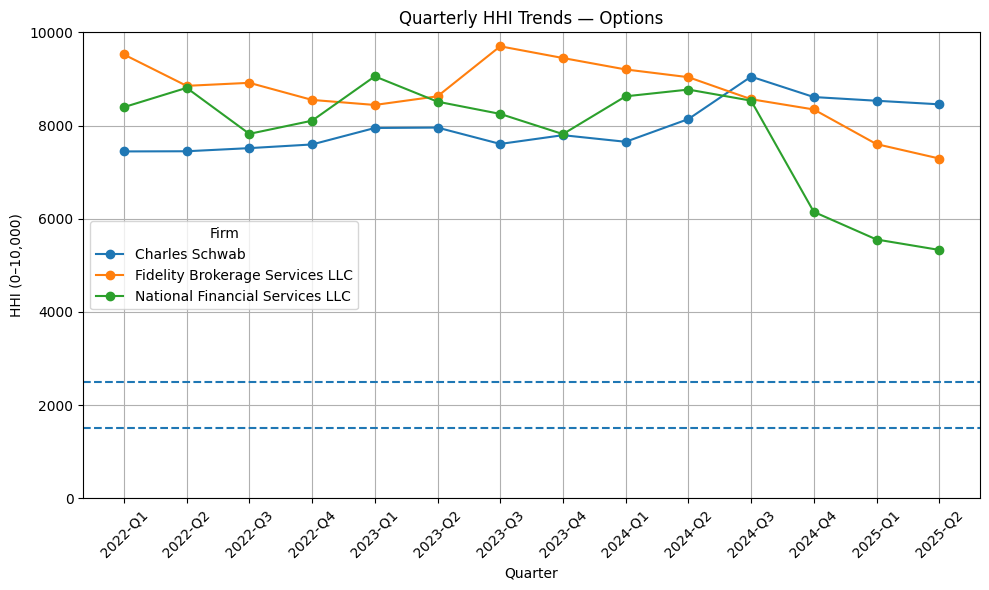

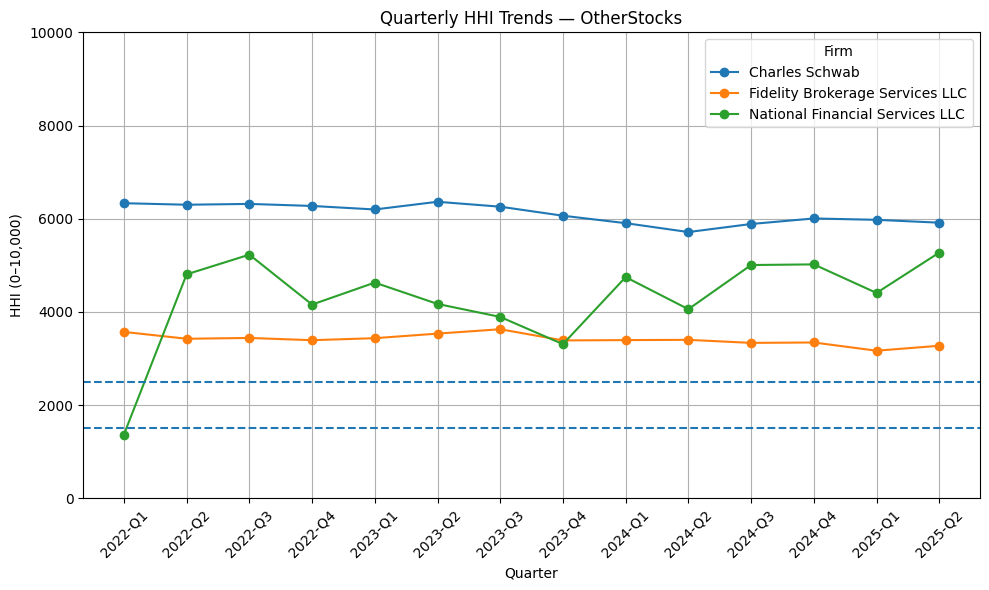

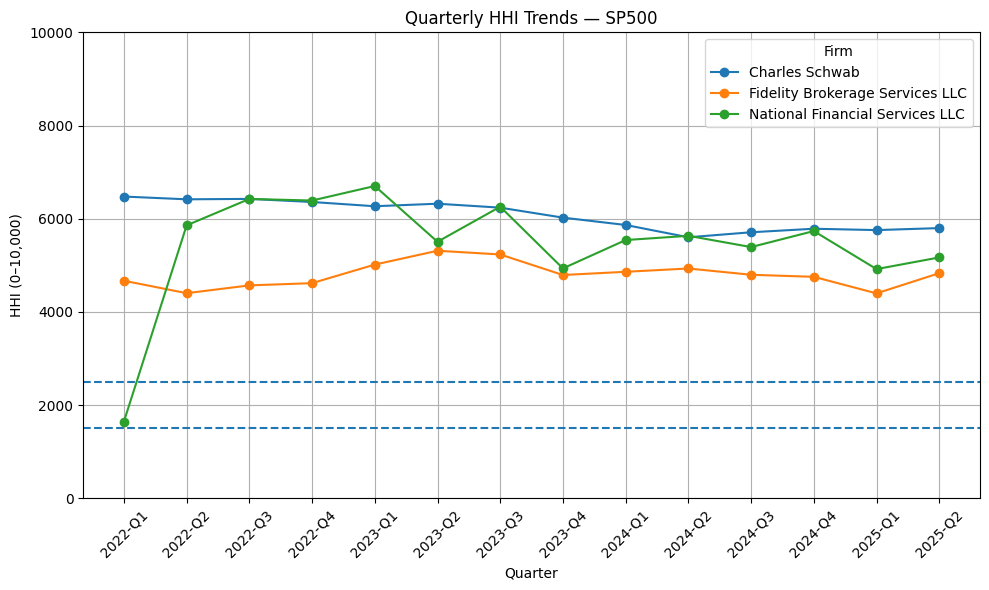

In [19]:
# INPUT expected: hhi_quarterly with columns:
# ['firm', 'yr_qtr', 'security_type', 'hhi']  where HHI is on 0–10,000 scale.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def _quarter_sort_keys(yr_qtr_series: pd.Series):
    # Parse "YYYY-QX" into (year, quarter) integers for proper sorting
    year = yr_qtr_series.str.slice(0, 4).astype(int)
    q = yr_qtr_series.str.extract(r'Q([1-4])', expand=False).astype(int)
    return year, q

def plot_quarterly_hhi_by_security(hhi_quarterly: pd.DataFrame):
    # Basic validation
    required = {'firm','yr_qtr','security_type','hhi_quarterly'}
    missing = required - set(hhi_quarterly.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    sec_types = (
        hhi_quarterly['security_type']
        .dropna()
        .astype(str)
        .unique()
    )

    for sec in sorted(sec_types):
        subset = hhi_quarterly[hhi_quarterly['security_type'] == sec].copy()

        # Build a canonical quarter order for the x-axis
        y, q = _quarter_sort_keys(subset['yr_qtr'])
        subset['_year'] = y
        subset['_q'] = q
        quarters = (
            subset.sort_values(['_year','_q'])['yr_qtr']
            .drop_duplicates()
            .tolist()
        )

        plt.figure(figsize=(10, 6))

        # Plot each firm on the same axes
        for firm in subset['firm'].astype(str).dropna().unique():
            f = subset[subset['firm'] == firm].copy()
            # Reindex to show gaps if a firm is missing a quarter
            f = (
                f.set_index('yr_qtr')
                 .reindex(quarters)
                 .reset_index()
                 .rename(columns={'index':'yr_qtr'})
            )
            plt.plot(f['yr_qtr'], f['hhi_quarterly'], marker='o', label=firm)

        # Reference lines for HHI interpretation
        plt.axhline(1500, linestyle='--')
        plt.axhline(2500, linestyle='--')

        plt.title(f'Quarterly HHI Trends — {sec}')
        plt.xlabel('Quarter')
        plt.ylabel('HHI (0–10,000)')
        plt.ylim(0, 10000)
        plt.xticks(rotation=45)
        plt.legend(title='Firm', loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ---- Run the plotter ----
plot_quarterly_hhi_by_security(hhi_quarterly)


##**7.2 Stability – Routing Consistency (std dev of HHI)**

**Stability – Routing Consistency (std dev of HHI):** Routing consistency measures how stable or erratic a broker’s venue selection is over time. We use the standard deviation of the Herfindahl-Hirschman Index (HHI) as the metric, higher variability means the broker’s routing patterns change more often, lower variability means they are steady.

General Ranges:

- < 200 = Stable, minor venue shifts. Routing is stable — broker sticks to the same venues.

- 400–600 = Noticeable but moderate shifts

- ≥ 1,000 = Large swings, potentially changing between dominant venues or routing models. Routing is volatile — broker changes venue mix frequently, which could signal opportunistic routing, market-making changes, or internalization shifts.



###**7.2.1  Intra-Quarter Routing Consistency per Broker per Security Type**

**Intra-Quarter Routing Consistency per Broker per Security Type:** This section looks at month-to-month stability inside a single quarter by computing the standard deviation of monthly HHI values per firm × security_type × yr_qtr.
- Captures short-term routing changes hidden in quarterly averages

- Useful for spotting sudden shifts in routing behavior within a reporting period

- Helps detect reactive changes to market conditions or incentives mid-quarter

In [20]:
# Calculate routing consistency score based on HHI for each quarter
# A higher standard deviation implies shifting routing patterns (lower reliability)
# Grouping is done at the firm and security_type level to preserve structure

hhi_monthly['yr_qtr'] = hhi_monthly['yr_qtr_mo'].str[:7]

merged_scores_sorted_qtr = hhi_monthly.sort_values(['firm', 'security_type', 'yr_qtr'])

routing_consistency_quarter = (
    merged_scores_sorted_qtr
    .groupby(['firm', 'security_type', 'yr_qtr'])['hhi_monthly']
    .std()
    .reset_index()
    .rename(columns={'hhi_monthly': 'routing_consistency_quarterly'})
)
routing_consistency_quarter['routing_consistency_quarterly'] = routing_consistency_quarter['routing_consistency_quarterly'].round(4)

# Only keep merge columns and target column from routing_consistency_quarter
routing_consistency_quarter = routing_consistency_quarter[
    ['firm', 'security_type', 'yr_qtr', 'routing_consistency_quarterly']
]

routing_consistency_quarter

/tmp/ipython-input-2915888003.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['firm', 'security_type', 'yr_qtr'])['hhi_monthly']


,firm,security_type,yr_qtr,routing_consistency_quarterly
0,Charles Schwab,Options,2022-Q1,379.8129
1,Charles Schwab,Options,2022-Q2,379.9922
2,Charles Schwab,Options,2022-Q3,383.4219
3,Charles Schwab,Options,2022-Q4,387.4481
4,Charles Schwab,Options,2023-Q1,405.5204
...,...,...,...,...
121,National Financial Services LLC,SP500,2024-Q2,288.3239
122,National Financial Services LLC,SP500,2024-Q3,275.6241
123,National Financial Services LLC,SP500,2024-Q4,293.2004
124,National Financial Services LLC,SP500,2025-Q1,252.2275


###**7.2.2 Routing Consistency per Broker per SecurityType**

**Routing Consistency per Broker per SecurityType:** Looks at longer-term stability by calculating the standard deviation of HHI values across the entire analysis period per firm × security_type.

- Identifies brokers whose routing is generally stable vs. those that frequently change venues over multiple quarters

- Supports longitudinal comparison across brokers and security types

- Works well as an input to composite “routing risk” scores

In [21]:
# Calculate routing consistency score based on  HHI for overall firm
# A higher standard deviation implies shifting routing patterns (lower reliability)
# Grouping is done at the firm and security_type level to preserve structure
# each firm & security type will only have one number

# Ensure data is ordered by time
merged_scores_sorted = hhi_monthly.sort_values(['firm', 'security_type', 'yr_qtr_mo'])

# Calculate std deviation of normalized HHI for each broker/security type
routing_consistency = (
    merged_scores_sorted
    .groupby(['firm', 'security_type'])['hhi_monthly']
    .std()
    .reset_index()
    .rename(columns={'hhi_monthly': 'routing_consistency_overall'})
)

# Round for clarity
routing_consistency['routing_consistency_overall'] = routing_consistency['routing_consistency_overall'].round(4)

routing_consistency


/tmp/ipython-input-307169371.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['firm', 'security_type'])['hhi_monthly']


,firm,security_type,routing_consistency_overall
0,Charles Schwab,Options,406.6178
1,Charles Schwab,OtherStocks,310.7111
2,Charles Schwab,SP500,309.2247
3,Fidelity Brokerage Services LLC,Options,444.7978
4,Fidelity Brokerage Services LLC,OtherStocks,173.4687
5,Fidelity Brokerage Services LLC,SP500,244.3928
6,National Financial Services LLC,Options,403.8666
7,National Financial Services LLC,OtherStocks,227.1118
8,National Financial Services LLC,SP500,283.7784


##**7.3 Incentive Pricing - Weighted CPH**

**Incentive Pricing - Weighted CPH:** Weighted Cents-Per-Hundred-Shares (CPH) represents the average payment or rebate a broker receives per 100 shares routed, weighted by the dollar amounts involved. This allows us to compare brokers’ routing incentives while accounting for trade volume and payment magnitude. Unweighted averages could be skewed by small trades with extreme CPH values. Weighting by total payments (*_usd) ensures that high-volume, high-value trades have appropriate influence on the average. <br>
Interpretation of Weighted CPH:

- Positive value: Broker receives net rebates from the venue (incentive to route there).

- Negative value: Broker pays the venue (potentially for execution quality, liquidity access, or other reasons).

- Higher absolute value: Stronger financial incentive, whether in the form of a rebate or payment.

###**7.3.1 Weighted Monthly CPH**

**Weighted Monthly CPH:** Calculates the weighted CPH at the month × broker × venue × security_type level.
- Captures short-term incentive fluctuations from month to month.

- Allows us to detect sudden changes in payment arrangements or routing incentives within a quarter.

- Provides granularity for venue-level incentive analysis.

In [22]:
#Compute monthly weighted CPH per firm × security_type using venue order_pct as weights to reflect real routing mix.
import numpy as np

# Filter the relevant CPH columns
cph_cols = [col for col in processed_monthly.columns if col.endswith('_cph')]

# Helper function for weighted average
def weighted_avg(group, value_col, weight_col='order_pct'):
    v = group[value_col]
    w = group[weight_col]
    return np.average(v, weights=w) if w.sum() > 0 else np.nan

# Initialize a dictionary to hold results
weighted_cph_dict = {}

# Loop through each CPH column to calculate weighted average
for cph_col in cph_cols:
    weighted = (
        processed_monthly
        .groupby(['firm', 'date','yr_qtr_mo', 'security_type'])
        .apply(lambda g: weighted_avg(g, cph_col))
        .reset_index(name=cph_col)
    )
    weighted_cph_dict[cph_col] = weighted

# Merge all weighted CPH columns together
from functools import reduce
weighted_cph_monthly = reduce(
    lambda left, right: pd.merge(left, right, on=['firm', 'date','yr_qtr_mo', 'security_type']),
    weighted_cph_dict.values()
)

weighted_cph_monthly


/tmp/ipython-input-196121173.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['firm', 'date','yr_qtr_mo', 'security_type'])
/tmp/ipython-input-196121173.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: weighted_avg(g, cph_col))
/tmp/ipython-input-196121173.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

,firm,date,yr_qtr_mo,security_type,net_pmt_paid_recv_market_orders_cph,net_pmt_paid_recv_marketable_limit_orders_cph,net_pmt_paid_recv_non_marketable_limit_orders_cph,net_pmt_paid_recv_other_orders_cph
0,Charles Schwab,2022-01-01,2022-Q1-01,Options,55.998421,59.459903,56.821906,43.549258
1,Charles Schwab,2022-01-01,2022-Q1-01,OtherStocks,9.919699,9.815160,28.966575,10.707261
2,Charles Schwab,2022-01-01,2022-Q1-01,SP500,9.940963,9.879480,32.014214,11.888152
3,Charles Schwab,2022-02-01,2022-Q1-02,Options,56.610643,60.227833,57.199153,41.970198
4,Charles Schwab,2022-02-01,2022-Q1-02,OtherStocks,9.930132,9.857708,28.447045,10.493830
...,...,...,...,...,...,...,...,...
373,National Financial Services LLC,2025-05-01,2025-Q2-05,OtherStocks,-0.044666,-0.022158,-0.018937,0.000000
374,National Financial Services LLC,2025-05-01,2025-Q2-05,SP500,0.000000,-0.064432,0.000000,0.000000
375,National Financial Services LLC,2025-06-01,2025-Q2-06,Options,6.489989,6.156535,-0.384034,-29.040166
376,National Financial Services LLC,2025-06-01,2025-Q2-06,OtherStocks,-0.085596,-0.066525,0.029244,-0.056818


###**7.3.2 Weighted Quarterly CPH**

**Weighted Quarterly CPH:** Aggregates monthly CPH into quarterly weighted averages per broker × security_type.
- Smooths short-term fluctuations to reveal sustained incentive patterns.

- Enables comparison of brokers’ long-term routing incentives across quarters.

- Works as a stable input to composite “routing risk” or “incentive risk” scores.

In [23]:
import numpy as np
from functools import reduce

# Identify CPH metric columns
cph_cols = [c for c in processed_quarterly.columns if c.endswith('_cph')]

def weighted_avg(group, value_col, weight_col='order_pct'):
    v = pd.to_numeric(group[value_col], errors='coerce')
    w = pd.to_numeric(group[weight_col], errors='coerce').fillna(0)
    mask = v.notna() & w.notna()
    total_w = w[mask].sum()
    return np.average(v[mask], weights=w[mask]) if total_w > 0 else np.nan

weighted_cph_qtr_dict = {}
for cph_col in cph_cols:
    weighted = (
        processed_quarterly
        .groupby(['firm','yr_qtr','security_type'], observed=True)
        .apply(lambda g, col=cph_col: weighted_avg(g, col))
        .reset_index(name=cph_col)
    )
    weighted_cph_qtr_dict[cph_col] = weighted

# Merge into a single quarterly weighted CPH table
weighted_cph_quarterly = reduce(
    lambda left, right: pd.merge(left, right, on=['firm','yr_qtr','security_type'], how='outer'),
    weighted_cph_qtr_dict.values()
)

weighted_cph_quarterly


/tmp/ipython-input-14851801.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g, col=cph_col: weighted_avg(g, col))
/tmp/ipython-input-14851801.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g, col=cph_col: weighted_avg(g, col))
/tmp/ipython-input-14851801.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and

,firm,yr_qtr,security_type,net_pmt_paid_recv_market_orders_cph,net_pmt_paid_recv_marketable_limit_orders_cph,net_pmt_paid_recv_non_marketable_limit_orders_cph,net_pmt_paid_recv_other_orders_cph
0,Charles Schwab,2022-Q1,Options,57.044077,60.711686,57.454254,42.655321
1,Charles Schwab,2022-Q1,OtherStocks,9.920508,9.838716,28.298956,10.532747
2,Charles Schwab,2022-Q1,SP500,9.941244,9.868499,31.854813,11.708855
3,Charles Schwab,2022-Q2,Options,56.673554,60.415531,57.203436,39.923714
4,Charles Schwab,2022-Q2,OtherStocks,9.877428,9.772455,27.422884,10.292128
...,...,...,...,...,...,...,...
121,National Financial Services LLC,2025-Q1,OtherStocks,-0.270096,-0.290048,-0.214661,-0.216495
122,National Financial Services LLC,2025-Q1,SP500,-0.079335,-0.098200,0.036376,0.000000
123,National Financial Services LLC,2025-Q2,Options,2.212841,4.421928,3.740363,-30.102973
124,National Financial Services LLC,2025-Q2,OtherStocks,-0.056921,-0.032581,0.013703,-0.032992


##**7.4 Composite Score**

###**7.4.1 Merge Metrics**

**Merge Metrics:** Merge quarterly information together and monthly data together to be used for data visualization.

**Data Dictionary**  
`scores_monthly` (Monthly Venue‑Level Metrics from Rule 606)

| Column Name | Type | Description |
|-------------|------|-------------|
| `firm` | object | Broker‑dealer name (e.g., “Fidelity Brokerage Services LLC”, “Charles Schwab”). |
| `date` | datetime64[ns] | Month reference date (month start set during processing). |
| `yr_qtr_mo` | object | Year‑Quarter‑Month label `YYYY-QX-MM` (e.g., `2024-Q3-07`). |
| `security_type` | category | Product bucket (e.g., `SP500`, `OtherStocks`, `Options`). |
| `hhi_monthly` | float64 | Monthly HHI concentration across venues for the broker/security type. |
| `yr_qtr` | object | Year‑Quarter label `YYYY-QX` (e.g., `2024-Q3`). |
| `venue_name` | object | Execution venue receiving routed orders. |
| `order_pct` | float64 | Share of total orders routed to this venue (% of broker’s flow for the month/security type). |
| `market_pct` | float64 | Market orders share routed to this venue (percent of broker’s monthly flow). |
| `marketable_limit_pct` | float64 | Marketable limit orders share routed to this venue (percent). |
| `non_marketable_limit_pct` | float64 | Non‑marketable limit orders share routed to this venue (percent). |
| `other_pct` | float64 | “Other” orders share routed to this venue (percent). |
| `net_pmt_paid_recv_market_orders_usd` | float64 | Net payment/fee for market orders at this venue (USD total in month). |
| `net_pmt_paid_recv_market_orders_cph` | float64 | Net payment/fee for market orders (cents per 100 shares) at this venue/month. |
| `net_pmt_paid_recv_marketable_limit_orders_usd` | float64 | Net payment/fee for marketable limit orders (USD total). |
| `net_pmt_paid_recv_marketable_limit_orders_cph` | float64 | Net payment/fee for marketable limit orders (CPH). |
| `net_pmt_paid_recv_non_marketable_limit_orders_usd` | float64 | Net payment/fee for non‑marketable limit orders (USD total). |
| `net_pmt_paid_recv_non_marketable_limit_orders_cph` | float64 | Net payment/fee for non‑marketable limit orders (CPH). |
| `net_pmt_paid_recv_other_orders_usd` | float64 | Net payment/fee for “other” orders (USD total). |
| `net_pmt_paid_recv_other_orders_cph` | float64 | Net payment/fee for “other” orders (CPH). |
| `material_aspects` | object | Free‑text disclosure from the XML describing material aspects/conflicts and routing arrangements. |


In [24]:
# Merge HHI quarterly and routing consistency quarterly
merged_scores = pd.merge(
    hhi_quarterly,
    routing_consistency_quarter,
    on=["firm", "yr_qtr", "security_type"],
    how="inner"
)

# Merge with weighted CPH quarterly
merged_scores = pd.merge(
    merged_scores,
    weighted_cph_quarterly,
    on=["firm", "yr_qtr", "security_type"],
    how="inner"
)


# Merge monthly data together
scores_monthly = pd.merge(
    hhi_monthly,
    processed_monthly,
    on=["firm", "yr_qtr_mo", "security_type",'date'],
    how="inner"
)



###**7.4.2 Composite Routing Risk Score**

**Composite Routing Risk Score:** Builds a 0–1 composite routing risk score per firm × security_type × quarter by (1) min–max normalizing three inputs within each security_type, then (2) averaging them with equal weights (⅓ each):

- Concentration: hhi_quarterly → hhi_norm

- Incentives: net_pmt_paid_recv_market_orders_cph → …_cph_norm

- Stability: routing_consistency_quarterly → routing_consistency_quarter_norm
- Higher score = more concentrated routing, stronger payment incentives, and choppier month-to-month behavior inside the quarter.

Why these choices: <br>
- Per-security-type normalization keeps equities vs options comparable and prevents one category from dominating due to scale.

- Min–max (0–1) scaling gives an intuitive, unit-free range and makes simple averaging meaningful.

- Equal weights are transparent and easy to defend; can be tune later if prefer.

- Market orders CPH selection: Chosen as the incentive metric because market orders are the most susceptible to payment-for-order-flow incentives. Unlike limit orders, they prioritize execution speed over price, giving brokers greater discretion to route them toward venues offering financial rebates. This order type best reflects payment-driven routing behavior and highlights potential conflicts of interest, making it a strong indicator of incentive-based decision-making.

**Data Dictionary**  
`merged_scores_norm` (Quarterly Routing Risk Inputs & Scores)

**Table 2. Quarterly Routing Risk Inputs & Scores**


| Column Name | Type | Description |
|-------------|------|-------------|
| `firm` | object | Broker name as reported in Rule 606 (e.g., “Fidelity Brokerage Services LLC”, “Charles Schwab”). |
| `yr_qtr` | object | Year–quarter label `YYYY-QX` (e.g., `2024-Q3`). |
| `security_type` | category | Security bucket for the order flow (e.g., `SP500`, `OtherStocks`, `Options`). |
| `hhi_quarterly` | float64 | Quarterly Herfindahl–Hirschman Index of venue concentration (higher = more concentrated routing). |
| `routing_consistency_quarterly` | float64 | Std dev of **monthly HHI** within the quarter (higher = more volatile/less stable routing). |
| `net_pmt_paid_recv_market_orders_cph` | float64 | Net payment-for-order-flow for **market orders**, cents per 100 shares (CPH), averaged over the quarter. |
| `net_pmt_paid_recv_marketable_limit_orders_cph` | float64 | Net PFOF for **marketable limit** orders, CPH, averaged over the quarter. |
| `net_pmt_paid_recv_non_marketable_limit_orders_cph` | float64 | Net PFOF for **non‑marketable limit** orders, CPH, averaged over the quarter. |
| `net_pmt_paid_recv_other_orders_cph` | float64 | Net PFOF for **other** order types, CPH, averaged over the quarter. |
| `hhi_norm` | float64 | Min–max normalized `hhi_quarterly` **within security_type** (0–1). |
| `routing_consistency_quarter_norm` | float64 | Min–max normalized `routing_consistency_quarterly` **within security_type** (0–1). |
| `net_pmt_paid_recv_market_orders_cph_norm` | float64 | Min–max normalized `net_pmt_paid_recv_market_orders_cph` **within security_type** (0–1). |
| `routing_risk_score` | float64 | Composite = average of `hhi_norm`, `net_pmt_paid_recv_market_orders_cph_norm`, and `routing_consistency_quarter_norm` (0–1; higher = higher routing risk). |


In [25]:
# --- Normalize each metric by security_type ---
merged_scores_norm = merged_scores.copy()
# Normalize HHI
merged_scores_norm['hhi_norm'] = (
    merged_scores_norm.groupby('security_type')['hhi_quarterly']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# Normalize routing consistency
merged_scores_norm['routing_consistency_quarter_norm'] = (
    merged_scores_norm.groupby('security_type')['routing_consistency_quarterly']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# Normalize market orders CPH
merged_scores_norm['net_pmt_paid_recv_market_orders_cph_norm'] = (
    merged_scores_norm.groupby('security_type')['net_pmt_paid_recv_market_orders_cph']
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# --- Calculate composite routing risk score (equal weights) ---
merged_scores_norm['routing_risk_score'] = (
    (1/3) * merged_scores_norm['hhi_norm'] +
    (1/3) * merged_scores_norm['net_pmt_paid_recv_market_orders_cph_norm'] +
    (1/3) * merged_scores_norm['routing_consistency_quarter_norm']
)

# round for readability
merged_scores_norm['routing_risk_score'] = merged_scores_norm['routing_risk_score'].round(4)


/tmp/ipython-input-3817474796.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_scores_norm.groupby('security_type')['hhi_quarterly']
/tmp/ipython-input-3817474796.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_scores_norm.groupby('security_type')['routing_consistency_quarterly']
/tmp/ipython-input-3817474796.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_scores_norm.groupby('security_t

#**8.0 Final Data Export for Tableau Dashboards**

In [26]:
#file saving step to export into tableau
merged_scores_norm.to_csv('merged_scores_monthly.csv', index=False)
scores_monthly.to_csv('scores_monthly.csv', index=False)